In [266]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
from config import path_to_repository
from analysis import BallBearingData # class for extracting all data from application and reapplication for ADC, IMU, and Camera Triggers
from analysis import DLC3DBendAngles # class for taking DLC 3d point data and converting to angles 
from analysis import bender_class # class for normalizing adc data, analyzing autobender tests
from analysis_adc_cam import ADC_CAM
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [268]:
# Upload ball bearing and beaker Trials from particpant
# Upload only the parent *date* folder (e.g., "9_19_25").
# If something fails, verify your folder structure matches the "9_19_25" example.

root_dir="CSV Data/11_4_25"
folder_suffix_first  = "B1_medm"       # e.g.  9_19_25_B1_slow
folder_suffix_second = "B2_medm"       # e.g.  9_19_25_B2_slow

#10_28_25 (Tom)
#10_29_25 (bending data might be okay...check...resistance changing)
#11_2_25 (good)
#11_4_25 (good)
#11_7_25 (missing 90 degree cam calibration)

##################### raw adc or imu data for any test ###############################



cam = ADC_CAM(
    root_dir=root_dir,
    path_to_repo=path_to_repository,
    folder_suffix_first=folder_suffix_first,
    folder_suffix_second=folder_suffix_second,
)

first_trials  = cam.load_first()
second_trials = cam.load_second()

n_first  = len(first_trials)
n_second = len(second_trials)

print("Number of first trials:", n_first)
print("Number of second trials:", n_second)


Number of first trials: 2
Number of second trials: 2


## Obtain raw ADC traces for tasks

In [270]:
adc_trials_first  = cam.extract_adc_dfs_by_trial(first_trials)
adc_trials_second = cam.extract_adc_dfs_by_trial(second_trials)

print("Number of first ADC trials:", len(adc_trials_first))
print("Number of second ADC trials:", len(adc_trials_second))


Number of first ADC trials: 2
Number of second ADC trials: 2


##  Obtain Camera/Protractor Calibration data and plot

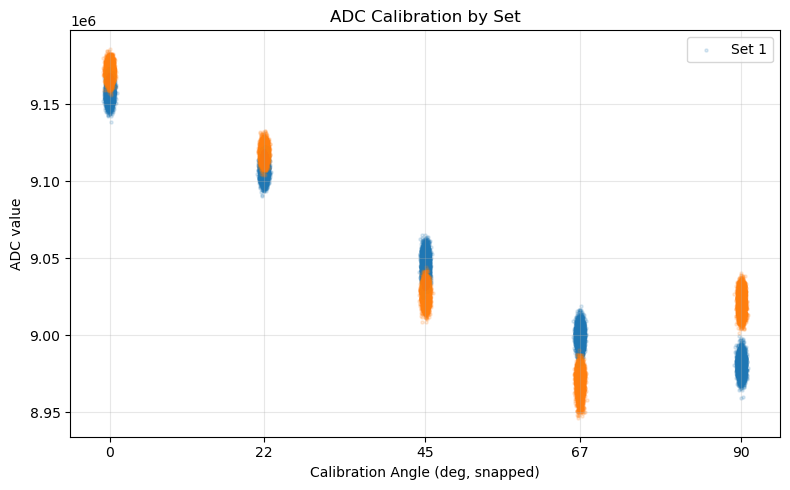

In [272]:
adc_cal_df = cam.extract_calib_means_by_set(
    adc_column="adc_ch3",             # or None to auto-pick
    exclude_name_contains=("C_Block",),
    exclude_sets=(3, 4),
    make_plot=True,
    overlay_mean=False,
    point_alpha=0.15,                 # maybe lower alpha for all points
    point_size=5,                     # smaller points for dense clouds
    jitter=0.25,
    snap_tol_deg=4.0,
    plot_all_data=True,               # <-- THIS plots all ADC samples
)



## Convert ADC values to angles using Camera / Protractor Calibration

In [274]:
out_cam = cam.calibrate_trials_with_camera(
    adc_trials_first=adc_trials_first,
    adc_trials_second=adc_trials_second,
    adc_column="adc_ch3",
    poly_order=2,
    calib_kwargs=dict(
        adc_column="adc_ch3",
        exclude_name_contains=("C_Block",),
        exclude_sets=(3, 4),
        make_plot=False,
        overlay_mean=False,
        point_alpha=0.25,
        point_size=10,
        jitter=0.25,
        snap_tol_deg=4.0,
    ),
    clamp_theta=True,   # <--- enable clamping
    deg_min=0.0,
    deg_max=90.0,
)

adc_first_theta  = out_cam["adc_trials_first_theta"]
adc_second_theta = out_cam["adc_trials_second_theta"]



# Get per-trial camera timestamp tables from flir.mat (prefix 'ts*') and DLC 3D point data (two separate dataframes)

This is where you should probably also load the DLC data and combine with cam_trials_first and cam_trials_second.    See my BallBearingClass for examples of how to do that.  

In [276]:
# ---------- 1) FLIR MAT per trial ----------
cam_trials_first = cam.extract_mat_dfs_by_trial(
    first_trials,
    mat_name="flir_data.mat",   # this matches your flir_data_*.mat files
    prefix="ts",
    add_labels=True,
    trial_base=1,
    set_label="first_cam",
    include_path=True,
)

cam_trials_second = cam.extract_mat_dfs_by_trial(
    second_trials,
    mat_name="flir_data.mat",
    prefix="ts",
    add_labels=True,
    trial_base=1,
    set_label="second_cam",
    include_path=True,
)

print("FLIR first:",  len(cam_trials_first))
print("FLIR second:", len(cam_trials_second))




FLIR first: 2
FLIR second: 2


In [277]:
# ---------- 2) DLC 3D per trial ----------
dlc3d_trials_first = cam.extract_dlc3d_dfs_by_trial(
    first_trials,
    add_labels=True,
    trial_base=1,
    set_label="first_cam",
    include_path=True,
)

dlc3d_trials_second = cam.extract_dlc3d_dfs_by_trial(
    second_trials,
    add_labels=True,
    trial_base=1,
    set_label="second_cam",
    include_path=True,
)

print("DLC first:",  len(dlc3d_trials_first))
print("DLC second:", len(dlc3d_trials_second))


DLC first: 2
DLC second: 2


In [278]:
# ---------- 3) Coerce DLC columns to MultiIndex using ADC_CAM helper ----------
dlc3d_trials_first  = [cam._coerce_dlc3d_multiindex(d)  for d in dlc3d_trials_first]
dlc3d_trials_second = [cam._coerce_dlc3d_multiindex(d) for d in dlc3d_trials_second]



C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating key

In [279]:
# ---------- 4) Compute MCP + wrist angles (per trial) ----------
dlc3d_trials_first  = [cam._coerce_dlc3d_multiindex(d)  for d in dlc3d_trials_first]
dlc3d_trials_second = [cam._coerce_dlc3d_multiindex(d) for d in dlc3d_trials_second]

aug_first,  tall_first  = cam.compute_dlc3d_angles_by_trial(
    dlc3d_trials_first,  set_label="first_cam",  signed_in_plane=True
)
aug_second, tall_second = cam.compute_dlc3d_angles_by_trial(
    dlc3d_trials_second, set_label="second_cam", signed_in_plane=True
)

print("len(aug_first) vs cam_trials_first:",
      len(aug_first), "vs", len(cam_trials_first))

print("len(aug_second) vs cam_trials_second:",
      len(aug_second), "vs", len(cam_trials_second))




len(aug_first) vs cam_trials_first: 2 vs 2
len(aug_second) vs cam_trials_second: 2 vs 2


## Combine DLC3D bend angles and .mat timestamp data

In [281]:
# ---------- 5) Attach FLIR timestamps to DLC angle trials ----------
dlc3D_angles_first  = cam.attach_cam_timestamps_to_angles(
    cam_trials_first,
    aug_first,
    time_col_name="timestamp",     # from _mat_to_df
    new_col_name="cam_timestamp",  # name of column in angles dfs
)

dlc3D_angles_second = cam.attach_cam_timestamps_to_angles(
    cam_trials_second,
    aug_second,
    time_col_name="timestamp",
    new_col_name="cam_timestamp",
)

print("len(dlc3D_angles_first):",  len(dlc3D_angles_first))
print("len(dlc3D_angles_second):", len(dlc3D_angles_second))




len(dlc3D_angles_first): 2
len(dlc3D_angles_second): 2


## Align Timestamps

In [283]:
# Align FIRST set: DLC MCP angles vs ADC-calibrated angles
merged_first = cam.align_adc_theta_to_dlc_angles_for_set(
    dlc_angle_trials=dlc3D_angles_first,
    adc_theta_trials=adc_first_theta,
    dlc_time_col="cam_timestamp",    # from attach_cam_timestamps_to_angles
    adc_time_col="timestamp",        # column in adc_first_theta
    adc_cols=["theta_cam_cal"],      # or None to attach all ADC columns
    time_unit="ns",                   # <-- try 's' first; use 'ms' if your timestamps are in milliseconds
    tolerance="50ms",
    direction="nearest",
    suffix="_adc",
    keep_time_delta=True,
    drop_unmatched=True,
)

# Align SECOND set
merged_second = cam.align_adc_theta_to_dlc_angles_for_set(
    dlc_angle_trials=dlc3D_angles_second,
    adc_theta_trials=adc_second_theta,
    dlc_time_col="cam_timestamp",
    adc_time_col="timestamp",
    adc_cols=["theta_cam_cal"],
    time_unit="ns",
    tolerance="50ms",
    direction="nearest",
    suffix="_adc",
    keep_time_delta=True,
    drop_unmatched=True,
)


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:4419: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8")
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:4420: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  enc_small["_t_enc_ns"] = enc_small["t_enc_td"].view("i8")
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:4419: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8"

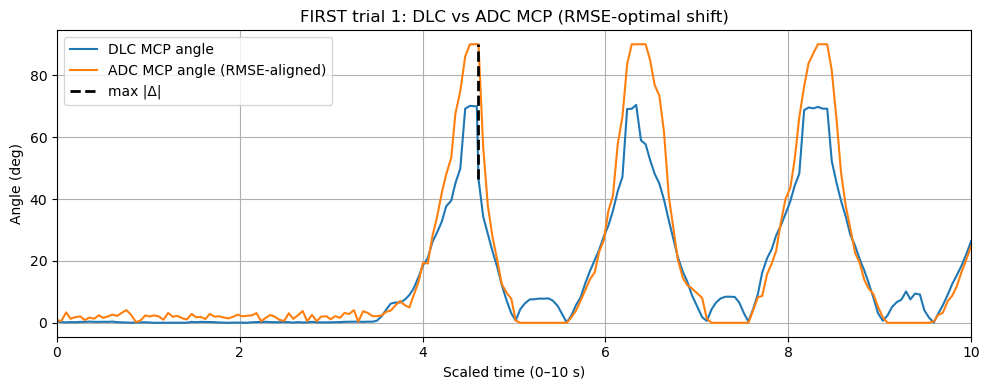

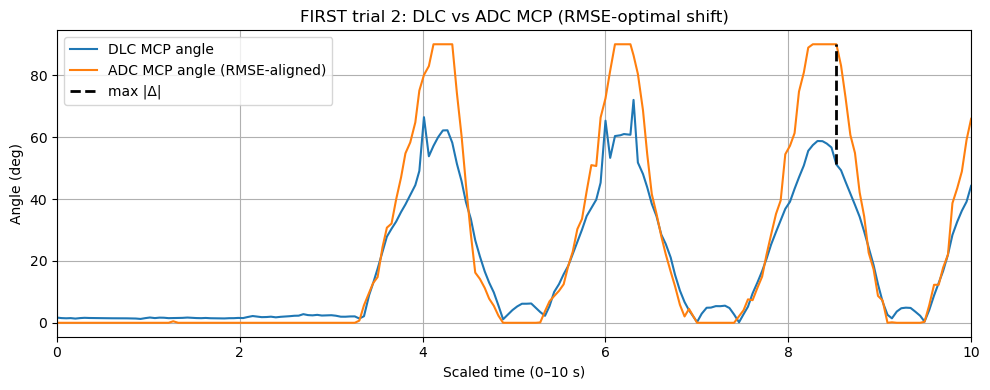

   trial_index  best_lag_samples   rmse_deg  n_points
0            0                 0   9.476131       197
1            1                 1  12.425242       197


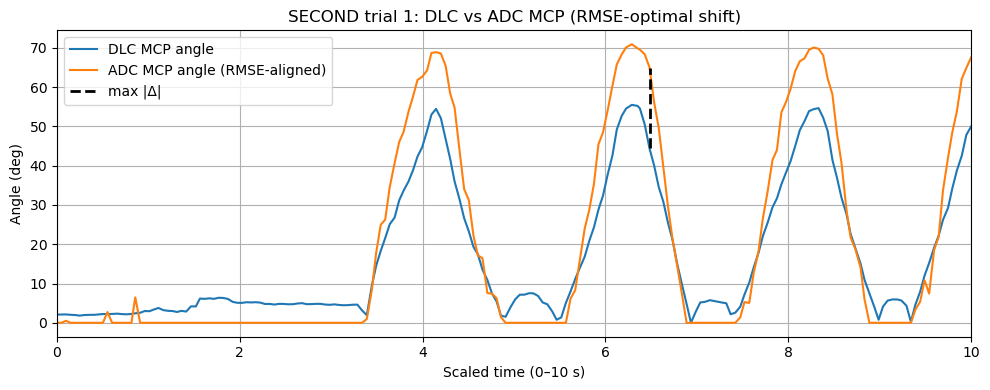

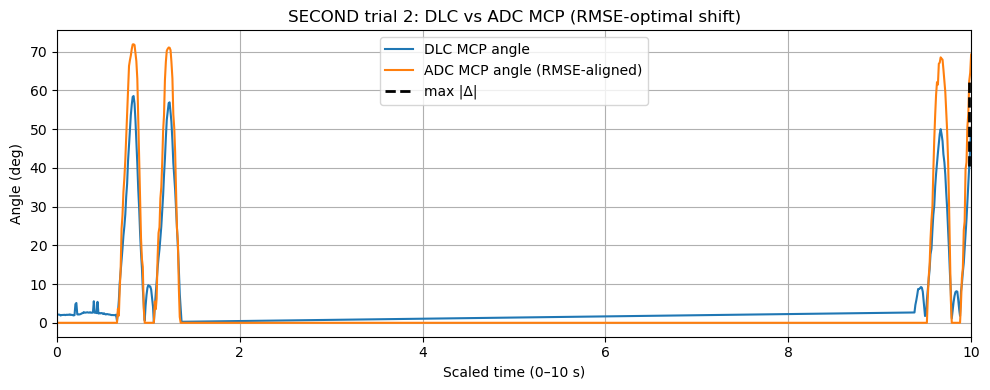

   trial_index  best_lag_samples   rmse_deg  n_points
0            0                 0   9.082262       197
1            1                 0  10.161126       197


In [284]:
# Refine FIRST set and plot a few trials
refined_first, summary_first = cam.refine_alignment_by_rmse_for_set(
    merged_trials=merged_first,
    dlc_col=("metric", "mcp_bend_deg", "deg"),
    adc_col="theta_cam_cal_adc",
    max_lag_samples=100, 
    time_col=("_t_cam_td", "", ""),   # or ("cam_timestamp", "", "")
    plot_indices=[0, 1],           # which trials to plot
    set_name="FIRST",
)

print(summary_first)

# Refine SECOND set and plot a few trials
refined_second, summary_second = cam.refine_alignment_by_rmse_for_set(
    merged_trials=merged_second,
    dlc_col=("metric", "mcp_bend_deg", "deg"),
    adc_col="theta_cam_cal_adc",
    max_lag_samples=100, 
    time_col=("_t_cam_td", "", ""),   # or ("cam_timestamp", "", "")
    plot_indices=[0, 1],           # which trials to plot
    set_name="SECOND",
)

print(summary_second)


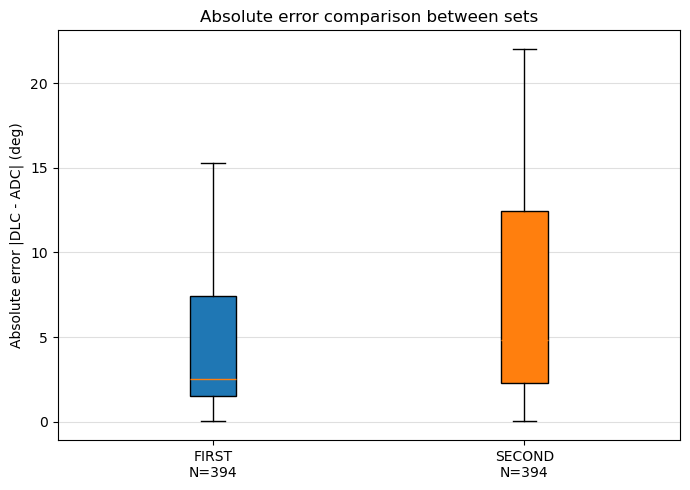

In [285]:
cam.plot_abs_error_box_two_sets(
    refined_first=refined_first,
    summary_first=summary_first,
    refined_second=refined_second,
    summary_second=summary_second,
    dlc_col=("metric", "mcp_bend_deg", "deg"),
    adc_rmse_col="theta_cam_cal_adc_rmse",
    trial_indices_first=[0, 1],    # FIRST set: trials 1 & 2 (0-based)
    trial_indices_second=[0, 1],   # SECOND set: trials 1 & 3
    label_first="FIRST",
    label_second="SECOND",
)




In [286]:
from typing import Optional, Sequence
# -----------------------------------------
# Helper: run full pipeline for one root_dir + speed
# -----------------------------------------

def run_adc_cam_pipeline_for_participant_speed(
    root_dir: str,
    speed_tag: str,
    *,
    path_to_repo: str,
    adc_column: str = "adc_ch3",
    calib_kwargs: Optional[dict] = None,
    time_unit: str = "ns",
    align_tolerance: str = "50ms",
    max_lag_samples: int = 100,
    trial_indices_first: Optional[Sequence[int]] = None,
    trial_indices_second: Optional[Sequence[int]] = None,
) -> dict:
    """
    Run the full ADC_CAM pipeline for a given participant/date (root_dir)
    and one speed condition (slow, medm, fast, vfas, afap).

    Uses explicit trial indices for each application (e.g. [0, 1]).

    Returns
    -------
    result : dict
        {
          "abs_err_first": np.ndarray,
          "abs_err_second": np.ndarray,
          "summary_first": pd.DataFrame,
          "summary_second": pd.DataFrame,
        }
    """

    # 1) Build ADC_CAM for this speed
    folder_suffix_first = f"B1_{speed_tag}"
    folder_suffix_second = f"B2_{speed_tag}"

    cam = ADC_CAM(
        root_dir=root_dir,
        path_to_repo=path_to_repo,
        folder_suffix_first=folder_suffix_first,
        folder_suffix_second=folder_suffix_second,
    )

    # 2) Load raw trials (paths)
    first_trials = cam.load_first()
    second_trials = cam.load_second()

    if len(first_trials) == 0 and len(second_trials) == 0:
        return {
            "abs_err_first": np.array([]),
            "abs_err_second": np.array([]),
            "summary_first": pd.DataFrame(),
            "summary_second": pd.DataFrame(),
        }

    # 3) Load ADC CSVs per trial
    adc_first = cam.extract_adc_dfs_by_trial(first_trials)
    adc_second = cam.extract_adc_dfs_by_trial(second_trials)

    # 4) Camera-based calibration (ADC -> theta)
    calib_result = cam.calibrate_trials_with_camera(
        adc_trials_first=adc_first,
        adc_trials_second=adc_second,
        adc_column=adc_column,
        poly_order=2,
        calib_kwargs=calib_kwargs,
        clamp_theta=True,
        deg_min=0.0,
        deg_max=90.0,
    )

    adc_first_theta = calib_result["adc_trials_first_theta"]
    adc_second_theta = calib_result["adc_trials_second_theta"]

    # 5) FLIR MAT per trial (timestamps)
    cam_trials_first = cam.extract_mat_dfs_by_trial(
        first_trials,
        mat_name="flir_data.mat",   # adjust if your name differs
        prefix="ts",
        add_labels=True,
        trial_base=1,
        set_label="first_cam",
        include_path=True,
    )
    cam_trials_second = cam.extract_mat_dfs_by_trial(
        second_trials,
        mat_name="flir_data.mat",
        prefix="ts",
        add_labels=True,
        trial_base=1,
        set_label="second_cam",
        include_path=True,
    )

    # 6) DLC per trial
    dlc3d_trials_first = cam.extract_dlc3d_dfs_by_trial(
        first_trials,
        add_labels=True,
        trial_base=1,
        set_label="first_cam",
        include_path=True,
    )
    dlc3d_trials_second = cam.extract_dlc3d_dfs_by_trial(
        second_trials,
        add_labels=True,
        trial_base=1,
        set_label="second_cam",
        include_path=True,
    )

    # 7) Coerce DLC -> MultiIndex and compute angles
    dlc3d_trials_first  = [cam._coerce_dlc3d_multiindex(d)  for d in dlc3d_trials_first]
    dlc3d_trials_second = [cam._coerce_dlc3d_multiindex(d) for d in dlc3d_trials_second]

    aug_first,  _ = cam.compute_dlc3d_angles_by_trial(
        dlc3d_trials_first,  set_label="first_cam",  signed_in_plane=True
    )
    aug_second, _ = cam.compute_dlc3d_angles_by_trial(
        dlc3d_trials_second, set_label="second_cam", signed_in_plane=True
    )

    # 8) Attach FLIR timestamps to DLC angle trials
    dlc3D_angles_first = cam.attach_cam_timestamps_to_angles(
        cam_trials_first, aug_first,
        time_col_name="timestamp",
        new_col_name="cam_timestamp",
    )
    dlc3D_angles_second = cam.attach_cam_timestamps_to_angles(
        cam_trials_second, aug_second,
        time_col_name="timestamp",
        new_col_name="cam_timestamp",
    )

    # 9) Align ADC-theta to DLC angles (time-based)
    merged_first = cam.align_adc_theta_to_dlc_angles_for_set(
        dlc_angle_trials=dlc3D_angles_first,
        adc_theta_trials=adc_first_theta,
        dlc_time_col="cam_timestamp",
        adc_time_col="timestamp",
        adc_cols=["theta_cam_cal"],
        time_unit=time_unit,
        tolerance=align_tolerance,
        direction="nearest",
        suffix="_adc",
        keep_time_delta=True,
        drop_unmatched=True,
    )

    merged_second = cam.align_adc_theta_to_dlc_angles_for_set(
        dlc_angle_trials=dlc3D_angles_second,
        adc_theta_trials=adc_second_theta,
        dlc_time_col="cam_timestamp",
        adc_time_col="timestamp",
        adc_cols=["theta_cam_cal"],
        time_unit=time_unit,
        tolerance=align_tolerance,
        direction="nearest",
        suffix="_adc",
        keep_time_delta=True,
        drop_unmatched=True,
    )

    # 10) RMSE-based refinement
    refined_first, summary_first = cam.refine_alignment_by_rmse_for_set(
        merged_trials=merged_first,
        dlc_col=("metric", "mcp_bend_deg", "deg"),
        adc_col="theta_cam_cal_adc",
        max_lag_samples=max_lag_samples,
        time_col=("_t_cam_td", "", ""),
        plot_indices=None,
        set_name=f"{speed_tag.upper()} FIRST",
    )

    refined_second, summary_second = cam.refine_alignment_by_rmse_for_set(
        merged_trials=merged_second,
        dlc_col=("metric", "mcp_bend_deg", "deg"),
        adc_col="theta_cam_cal_adc",
        max_lag_samples=max_lag_samples,
        time_col=("_t_cam_td", "", ""),
        plot_indices=None,
        set_name=f"{speed_tag.upper()} SECOND",
    )

    # 11) Collect abs-error distributions using explicit trial indices
    abs_err_first = cam.collect_abs_error_for_set(
        refined_first,
        summary_first,
        dlc_col=("metric", "mcp_bend_deg", "deg"),
        adc_rmse_col="theta_cam_cal_adc_rmse",
        trial_indices=trial_indices_first,
        n_best=2,
    )
    abs_err_second = cam.collect_abs_error_for_set(
        refined_second,
        summary_second,
        dlc_col=("metric", "mcp_bend_deg", "deg"),
        adc_rmse_col="theta_cam_cal_adc_rmse",
        trial_indices=trial_indices_second,
        n_best=2,
    )

    return {
        "abs_err_first": abs_err_first,
        "abs_err_second": abs_err_second,
        "summary_first": summary_first,
        "summary_second": summary_second,
    }


Processing P1 - slow ...
[INFO] _mat_to_df: trimming arrays in flir_data_2025_11_02_14_46_39_B_slow.mat to min length 197 (lengths were: {'ts_25183199': 198, 'ts_25185174': 197})


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating key

Processing P1 - medm ...
[INFO] _mat_to_df: trimming arrays in flir_data_2025_11_02_14_29_26_B_medm.mat to min length 197 (lengths were: {'ts_25183199': 198, 'ts_25185174': 197})


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating key

Processing P1 - fast ...


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating key

Processing P1 - vfas ...
[INFO] _mat_to_df: trimming arrays in flir_data_2025_11_02_15_40_36_B_vfas.mat to min length 197 (lengths were: {'ts_25183199': 198, 'ts_25185174': 197})


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating key

Processing P1 - afap ...
[INFO] _mat_to_df: trimming arrays in flir_data_2025_11_02_14_35_31_B_afap.mat to min length 197 (lengths were: {'ts_25183199': 198, 'ts_25185174': 197})
[INFO] _mat_to_df: trimming arrays in flir_data_2025_11_02_15_41_31_B_afap.mat to min length 197 (lengths were: {'ts_25183199': 198, 'ts_25185174': 197})


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating key

Processing P2 - slow ...


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating key

Processing P2 - medm ...


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating key

Processing P2 - fast ...


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating key

Processing P2 - vfas ...


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating key

Processing P2 - afap ...


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp = str(body_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = str(coord_row[j])
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis_adc_cam.py:1159: FutureWarning: Series.__getitem__ treating key

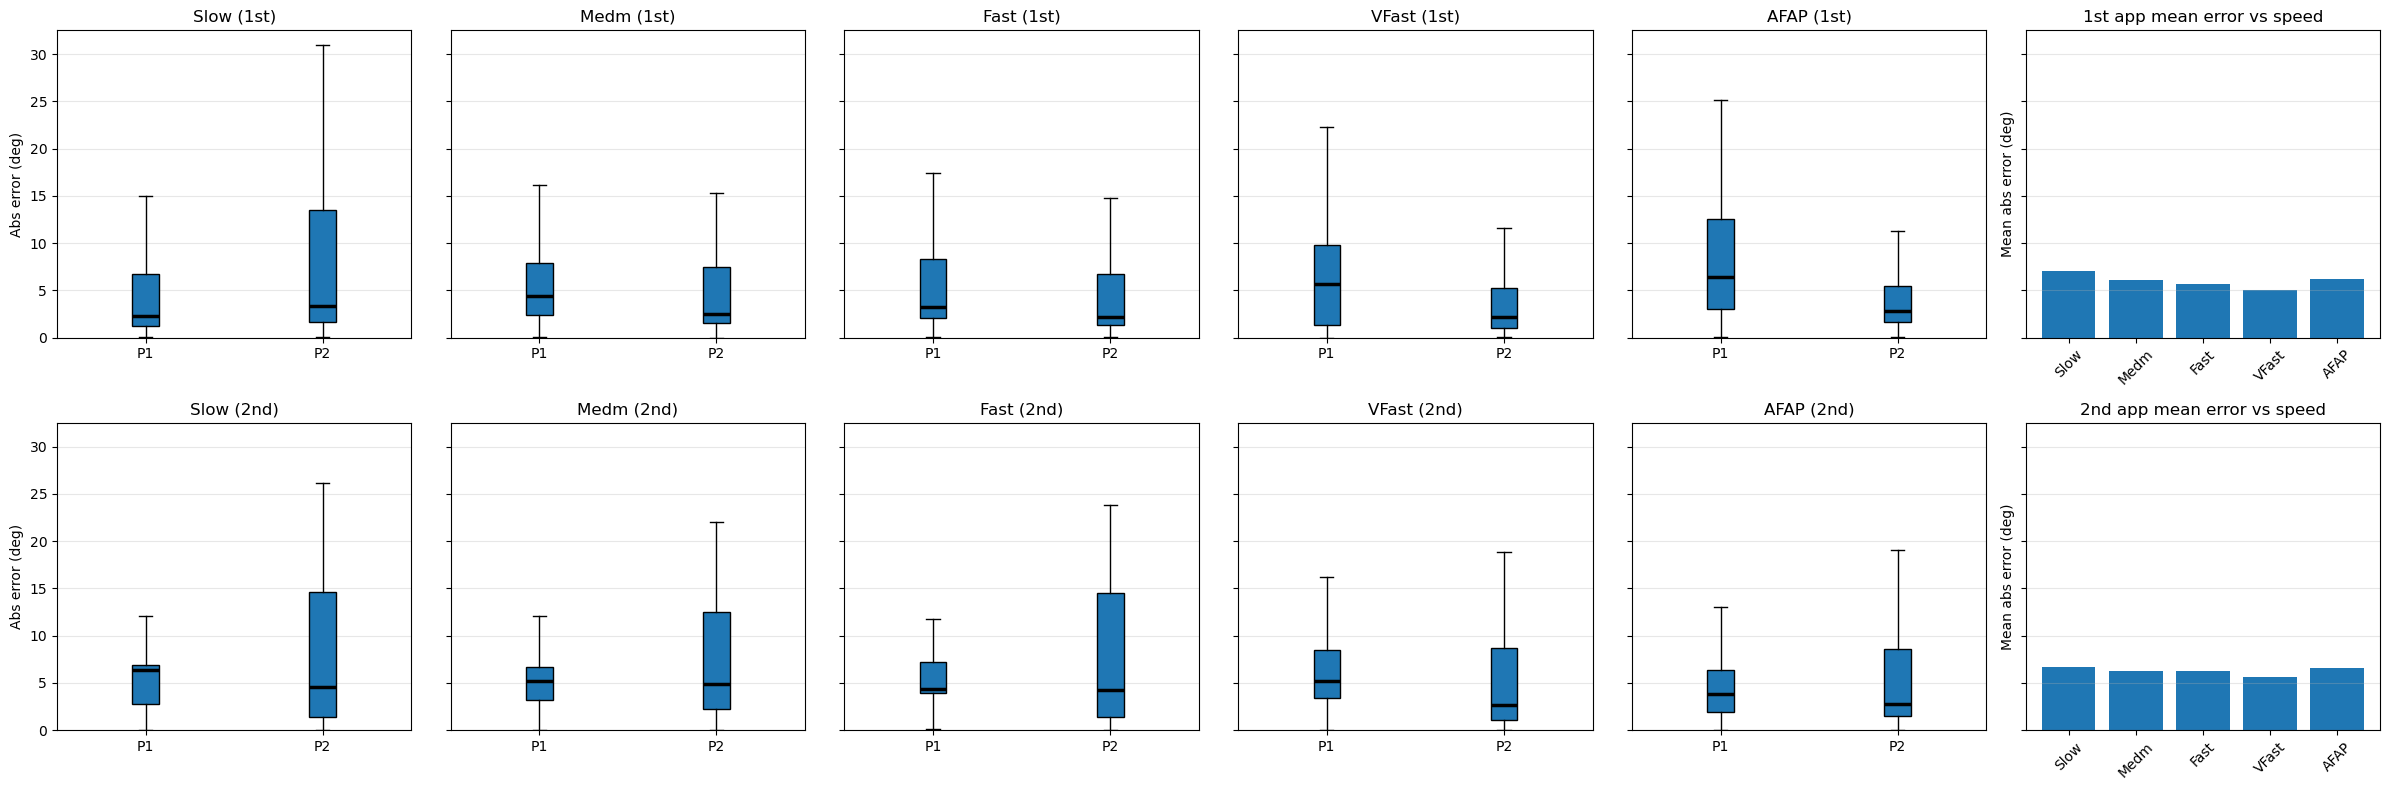

In [287]:
# -----------------------------------------
# CONFIG: participants, speeds, and trial indices
# -----------------------------------------

participants = [
    {"name": "P1", "root_dir": "CSV Data/11_2_25"},
    {"name": "P2", "root_dir": "CSV Data/11_4_25"},
]

speed_tags   = ["slow", "medm", "fast", "vfas", "afap"]
speed_titles = ["Slow", "Medm", "Fast", "VFast", "AFAP"]

# Explicit trial indices to use for EACH speed + set
# (You can make this a dict keyed by speed/participant if you want more control.)
trial_indices_first_default  = [0, 1]  # B1_* application
trial_indices_second_default = [0, 1]  # B2_* application


# -----------------------------------------
# Run pipeline for all (participant, speed)
# -----------------------------------------

results = {}  # (participant_name, speed_tag) -> dict from helper

for p in participants:
    for speed in speed_tags:
        key = (p["name"], speed)
        print(f"Processing {p['name']} - {speed} ...")
        res = run_adc_cam_pipeline_for_participant_speed(
            root_dir=p["root_dir"],
            speed_tag=speed,
            path_to_repo=path_to_repository,
            adc_column="adc_ch3",
            calib_kwargs=None,
            time_unit="ns",
            align_tolerance="50ms",
            max_lag_samples=100,
            trial_indices_first=trial_indices_first_default,
            trial_indices_second=trial_indices_second_default,
        )
        results[key] = res


# -----------------------------------------
# Build 2×6 summary figure:
# row 1: B1_* (FIRST application)
# row 2: B2_* (SECOND application)
# cols 1–5: per-speed boxplots (one blue box per participant)
# col 6: summary bar (mean abs error vs speed)
# -----------------------------------------

fig, axes = plt.subplots(2, 6, figsize=(24, 8), sharey=True)

def style_blue_boxplot(ax, data, labels):
    bp = ax.boxplot(
        data,
        labels=labels,
        showfliers=False,
        patch_artist=True,
    )
    # All boxes blue
    for box in bp["boxes"]:
        box.set_facecolor("C0")
    # Medians black + thick
    for med in bp["medians"]:
        med.set_color("k")
        med.set_linewidth(2.5)
    return bp

# --- row 1: FIRST set (B1_*) ---
for col, (speed, speed_title) in enumerate(zip(speed_tags, speed_titles)):
    ax = axes[0, col]
    data = []
    labels = []
    for p in participants:
        key = (p["name"], speed)
        abs_err = results.get(key, {}).get("abs_err_first", np.array([]))
        if abs_err.size == 0:
            continue
        data.append(abs_err)
        labels.append(p["name"])
    if data:
        style_blue_boxplot(ax, data, labels)
    ax.set_title(f"{speed_title} (1st)")
    if col == 0:
        ax.set_ylabel("Abs error (deg)")
    ax.grid(axis="y", alpha=0.3)

# --- row 2: SECOND set (B2_*) ---
for col, (speed, speed_title) in enumerate(zip(speed_tags, speed_titles)):
    ax = axes[1, col]
    data = []
    labels = []
    for p in participants:
        key = (p["name"], speed)
        abs_err = results.get(key, {}).get("abs_err_second", np.array([]))
        if abs_err.size == 0:
            continue
        data.append(abs_err)
        labels.append(p["name"])
    if data:
        style_blue_boxplot(ax, data, labels)
    ax.set_title(f"{speed_title} (2nd)")
    if col == 0:
        ax.set_ylabel("Abs error (deg)")
    ax.grid(axis="y", alpha=0.3)

# --- Column 6 (index 5): summary bar plots of mean error per speed ---

# Row 1 summary: FIRST set
ax_sum_first = axes[0, 5]
mean_first = []
for speed in speed_tags:
    all_err = []
    for p in participants:
        key = (p["name"], speed)
        abs_err = results.get(key, {}).get("abs_err_first", np.array([]))
        if abs_err.size > 0:
            all_err.append(abs_err)
    if all_err:
        all_err = np.concatenate(all_err)
        mean_first.append(np.nanmean(all_err))
    else:
        mean_first.append(np.nan)

x = np.arange(len(speed_tags))
ax_sum_first.bar(x, mean_first, color="C0")
ax_sum_first.set_xticks(x)
ax_sum_first.set_xticklabels(speed_titles, rotation=45)
ax_sum_first.set_ylabel("Mean abs error (deg)")
ax_sum_first.set_title("1st app mean error vs speed")
ax_sum_first.grid(axis="y", alpha=0.3)

# Row 2 summary: SECOND set
ax_sum_second = axes[1, 5]
mean_second = []
for speed in speed_tags:
    all_err = []
    for p in participants:
        key = (p["name"], speed)
        abs_err = results.get(key, {}).get("abs_err_second", np.array([]))
        if abs_err.size > 0:
            all_err.append(abs_err)
    if all_err:
        all_err = np.concatenate(all_err)
        mean_second.append(np.nanmean(all_err))
    else:
        mean_second.append(np.nan)

ax_sum_second.bar(x, mean_second, color="C0")
ax_sum_second.set_xticks(x)
ax_sum_second.set_xticklabels(speed_titles, rotation=45)
ax_sum_second.set_ylabel("Mean abs error (deg)")
ax_sum_second.set_title("2nd app mean error vs speed")
ax_sum_second.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()